In [ ]:
# TODO 1. FINALIZE THE REMOVAL OF ROWS
# TODO 2. CREATE SCRIPT THAT CALLS ALL .maf FILES AND EXECUTES THE PCA, BAYPASS AND POPOOLATION SCRIPTS
# TODO 3. CONVERT ALL IPYNB FILES TO PY FILES
# TODO 4. CREATE THE BASH SCRIPT FOR THE ANALYSIS. TRY TO APPROXIMATE HOW MUCH TIME THE ANALYSIS WILL TAKE FOR ALL OF THE POPULATIONS BY CALCULATING BASED ON THE TOTAL FILE SIZE

# PCA

We work with the biallelic SNP file

step 1: note the order of the populations as the order will prove useful to know in the final figure (to know which population is which)

step 2: for the PCA we will need the frequency of one of the two alleles,
otherwise the dataset becomes orthogonal and it doesn't work with the PCA.

## Import necessary libraries

In [44]:
import pandas as pd 
import numpy as np
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
# import os

## Import the maf csv file

In [45]:
maf_filename = r"maf_LR537144.csv"
result_biallelic=pd.read_csv(maf_filename)
result_biallelic

,chr,pos,index,ref_n,A,C,G,T,A.1,C.1,...,G.20,T.20,A.21,C.21,G.21,T.21,A.22,C.22,G.22,T.22
0,LR537144.1,10000025,6430776,C,0,67,0,92,0,75,...,0,7,0,56,0,11,0,35,0,30
1,LR537144.1,10000130,6430850,G,0,98,62,0,0,48,...,56,0,0,15,62,0,0,23,40,0
2,LR537144.1,10000201,6430923,T,0,15,0,152,0,27,...,0,56,0,17,0,77,0,17,0,55
3,LR537144.1,10000306,6431037,G,0,0,132,0,0,0,...,77,0,0,3,65,0,0,0,67,0
4,LR537144.1,10000606,6431194,T,0,0,0,122,0,0,...,0,75,0,0,0,77,0,0,0,77
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160545,LR537144.1,9999619,413689,A,41,0,142,0,48,0,...,41,0,42,0,32,0,32,0,37,0
160546,LR537144.1,9999796,413868,T,0,114,0,33,0,59,...,0,13,0,25,0,53,0,37,0,25
160547,LR537144.1,9999827,413895,a,131,0,11,0,91,0,...,0,0,92,0,0,0,61,0,2,0
160548,LR537144.1,9999900,413963,G,73,0,72,0,50,0,...,48,0,17,0,64,0,34,0,44,0


## Remove rows where the sum of all nucleotides is zero

In [46]:
def detect_zero_sum_rows(input_dataframe):
    # Extract only the columns corresponding to allele counts (A, T, C, G)
    allele_columns = input_dataframe.iloc[:, 4:]  # Ignoring the first 4 columns: chr, pos, index, ref_n
    
    # Group the data in sets of 4 columns (A, T, C, G) per sample
    num_samples = allele_columns.shape[1] // 4
    
    # Create 3D numpy array with rows (genomic positions), columns (samples), allele counts (ATCG) as dimensions
    reshaped_data = allele_columns.to_numpy().reshape(allele_columns.shape[0], num_samples, 4)
    
    # Sum ATCG values for each sample
    allele_sums = reshaped_data.sum(axis=2)
    
    # Extract the positions and rows where any sample has an allele sum of zero
    zero_sum_positions = input_dataframe[np.any(allele_sums == 0, axis=1)]
    zero_sum_indices = zero_sum_positions.index.tolist()    
    
    # Display first few rows with zero allele sum for inspection
    # print(zero_sum_positions.head())
    
    all_values = allele_columns.to_numpy()
    
    # -----------------------------------------------------------
    # For logging purposes:
    # Note: This is the total count of ATCG sums equaling zero. 
    # This means that we might have many zero sum instances in the same position. 
    
    
    zero_count = np.sum(allele_sums == 0) 
    nan_count = np.sum(np.isnan(all_values))
    
    
    # Create the log folder if it doesn't already exist
    # log_folder_path = '\zero_sum_logs'
    # os.makedirs(log_folder_path, exist_ok=True)
    # # Define log file path
    # log_path = os.path.join(log_folder_path, f'{maf_filename}.txt')
    
    # Write the total ATCG zero sum instances count and total nan count to the combined log file
    # with open(log_path, 'w') as log_file:
    #     log_file.write(f"Number of rows with zero allele sum: {zero_sum_positions.shape[0]}")
    #     log_file.write(f"Total ATCG zero sum instances count: {zero_count}")
    #     log_file.write(f"Total nan count: {nan_count}")
    
    print(f"Number of rows with zero allele sum: {zero_sum_positions.shape[0]}")
    print(f"Total ATCG zero sum instances count: {zero_count}")
    print(f"Total nan count: {nan_count}")
    # TODO: Create output log files
    # -----------------------------------------------------------
    
    return zero_sum_indices

# Example usage
result_biallelic = result_biallelic.drop(detect_zero_sum_rows(result_biallelic))


Number of rows with zero allele sum: 3
Total ATCG zero sum instances count: 7
Total nan count: 0


In [47]:
result_biallelic

,chr,pos,index,ref_n,A,C,G,T,A.1,C.1,...,G.20,T.20,A.21,C.21,G.21,T.21,A.22,C.22,G.22,T.22
0,LR537144.1,10000025,6430776,C,0,67,0,92,0,75,...,0,7,0,56,0,11,0,35,0,30
1,LR537144.1,10000130,6430850,G,0,98,62,0,0,48,...,56,0,0,15,62,0,0,23,40,0
2,LR537144.1,10000201,6430923,T,0,15,0,152,0,27,...,0,56,0,17,0,77,0,17,0,55
3,LR537144.1,10000306,6431037,G,0,0,132,0,0,0,...,77,0,0,3,65,0,0,0,67,0
4,LR537144.1,10000606,6431194,T,0,0,0,122,0,0,...,0,75,0,0,0,77,0,0,0,77
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160545,LR537144.1,9999619,413689,A,41,0,142,0,48,0,...,41,0,42,0,32,0,32,0,37,0
160546,LR537144.1,9999796,413868,T,0,114,0,33,0,59,...,0,13,0,25,0,53,0,37,0,25
160547,LR537144.1,9999827,413895,a,131,0,11,0,91,0,...,0,0,92,0,0,0,61,0,2,0
160548,LR537144.1,9999900,413963,G,73,0,72,0,50,0,...,48,0,17,0,64,0,34,0,44,0


The function "major_allele_freq_calc" below
estimates the major allele frequency of the FIRST population rounded to third decimal for every pop - position
then it estimates the allele frequency of the SAME allele in the rest of the populations
pca will be based on the allele frequency of that same allele across populations

In [48]:
def major_allele_freq_calc(input_dataframe):
    # Convert DataFrame to numpy array for faster operations (around 300x speed benefit, 00:03 vs 09:14)
    # We convert the dataframe but without the first 4 columns
    genetic_data = input_dataframe.iloc[:, 4:].to_numpy() 

    # Calculate the number of samples (assuming 4 columns per sample)
    num_samples = genetic_data.shape[1] // 4

    # Group alleles for each sample. Reorganize the data into a 3D array: (number of SNPs, number of samples, 4 alleles per sample)
    reshaped_data = genetic_data.reshape(genetic_data.shape[0], num_samples, 4)

    # Find the index of the maximum value in the first sample. Identify the major allele based on the first sample
    max_indices = reshaped_data[:, 0, :].argmax(axis=1)

    # Calculate major allele frequencies
    major_allele_freqs = np.zeros((reshaped_data.shape[0], num_samples))
    for i in range(num_samples):
        sample_data = reshaped_data[:, i, :]
        major_alleles = sample_data[np.arange(sample_data.shape[0]), max_indices]
        allele_sums = sample_data.sum(axis=1)
        major_allele_freqs[:, i] = np.round(major_alleles / allele_sums, 3) 
    

    result_dict = {input_dataframe.iloc[i, 1]: list(major_allele_freqs[i]) for i in tqdm(range(genetic_data.shape[0]), 
                                                                                        desc="Creating dictionary", 
                                                                                        unit="row")
    }
    
    return result_dict



In [49]:
result_dict = major_allele_freq_calc(result_biallelic)

Creating dictionary: 100%|██████████| 160547/160547 [00:04<00:00, 36906.96row/s]


In [50]:
# Function to check for inf, nan, and zero values
def check_special_values(result_dict):
    all_values = np.array(list(result_dict.values()))
    
    inf_count = np.sum(np.isinf(all_values))
    nan_count = np.sum(np.isnan(all_values))
    zero_count = np.sum(all_values == 0)
    
    print(f"Total values: {all_values.size}")
    print(f"Infinity values: {inf_count}")
    print(f"NaN values: {nan_count}")
    print(f"Zero values: {zero_count}")
    
    if inf_count > 0:
        inf_positions = [(key, i) for key, values in result_dict.items() for i, v in enumerate(values) if np.isinf(v)]
        print("\nExample positions with infinity:")
        for key, i in inf_positions[:5]:  # Print first 5 examples
            print(f"Position {key}, Sample {i+1}: {result_dict[key][i]}")
    
    if nan_count > 0:
        nan_positions = [(key, i) for key, values in result_dict.items() for i, v in enumerate(values) if np.isnan(v)]
        print("\nExample positions with NaN:")
        for key, i in nan_positions[:7]:  # Print first 5 examples
            print(f"Position {key}, Sample {i+1}: {result_dict[key][i]}")
    
    if zero_count > 0:
        zero_positions = [(key, i) for key, values in result_dict.items() for i, v in enumerate(values) if v == 0]
        print("\nExample positions with zero:")
        for key, i in zero_positions[:10]:  # Print first 5 examples
            print(f"Position {key}, Sample {i+1}: {result_dict[key][i]}")

# Check the result_dict
check_special_values(result_dict)

Total values: 3692581
Infinity values: 0
NaN values: 0
Zero values: 10

Example positions with zero:
Position 15192694, Sample 14: 0.0
Position 17099196, Sample 7: 0.0
Position 17286520, Sample 22: 0.0
Position 18363087, Sample 23: 0.0
Position 19713173, Sample 8: 0.0
Position 19713173, Sample 13: 0.0
Position 21451495, Sample 21: 0.0
Position 2819685, Sample 23: 0.0
Position 6016709, Sample 8: 0.0
Position 6848695, Sample 21: 0.0


In [51]:
major_alllele_freq_df = pd.DataFrame(result_dict)
major_alllele_freq_df

,10000025,10000130,10000201,10000306,10000606,10000639,10000718,10000750,10000766,10000769,...,9999510,9999520,9999551,9999557,9999574,9999619,9999796,9999827,9999900,9999957
0,0.579,0.612,0.910,1.000,1.000,0.976,1.000,0.939,0.847,1.000,...,0.918,0.860,0.912,1.000,0.926,0.776,0.776,0.923,0.503,0.951
1,0.419,0.387,0.794,1.000,1.000,0.981,1.000,0.974,0.932,1.000,...,0.917,0.936,0.923,0.932,0.900,0.642,0.615,0.948,0.455,0.955
2,0.415,0.403,0.908,0.977,1.000,0.969,0.960,0.970,0.713,0.970,...,0.912,0.782,0.905,0.971,0.888,0.758,0.711,0.906,0.450,0.982
3,0.225,0.237,0.772,0.852,1.000,0.915,1.000,0.915,0.955,1.000,...,0.711,0.914,0.690,0.937,0.685,0.630,0.639,1.000,0.228,1.000
4,0.307,0.277,0.793,0.971,1.000,1.000,0.988,1.000,0.818,1.000,...,0.816,0.924,0.822,0.955,0.830,0.621,0.583,1.000,0.328,0.973
5,0.462,0.522,0.861,1.000,1.000,0.944,1.000,0.884,0.871,0.961,...,0.847,0.899,0.844,0.918,0.858,0.675,0.728,1.000,0.473,0.986
6,0.300,0.377,0.829,0.938,1.000,0.955,0.953,0.925,0.713,0.815,...,0.812,0.825,0.793,1.000,0.833,0.679,0.681,1.000,0.398,0.985
7,0.436,0.421,0.888,1.000,1.000,0.984,1.000,0.952,0.529,1.000,...,0.910,0.840,0.875,0.912,0.865,0.755,0.768,0.959,0.478,1.000
8,0.508,0.465,0.850,1.000,0.924,0.960,1.000,0.962,0.814,0.960,...,0.949,0.866,0.926,0.948,0.924,0.713,0.743,1.000,0.535,0.978
9,0.509,0.510,0.922,1.000,1.000,1.000,1.000,1.000,0.814,0.960,...,0.932,0.940,0.922,1.000,0.873,0.667,0.786,0.909,0.548,1.000


conduct the PCA analysis using the PCA function of the sklearn package

standard scaler standardizes the variance of each row to unit and scales the data to zero

this way makes possible for PCA to work as unequal variances ineterfere with the PCA results

In [52]:
scaler = StandardScaler()
scaler.fit(major_alllele_freq_df)

StandardScaler()

In [53]:
scaled_data=pd.DataFrame(scaler.transform(major_alllele_freq_df))
# Replace 'nan' and 'inf' values with 0
scaled_data = scaled_data.replace([np.nan, -np.inf], 0)

In [54]:
scaled_data

,0,1,2,3,4,5,6,7,8,9,...,160537,160538,160539,160540,160541,160542,160543,160544,160545,160546
0,1.396870,1.571180,0.915783,0.509538,0.353784,0.664554,0.697848,-0.233106,0.509195,0.713032,...,0.894957,-0.120125,0.851313,0.975490,1.139004,1.346928,0.955537,-1.317106,0.600966,-1.285192
1,0.082169,-0.220152,-0.575859,0.509538,0.353784,0.803760,0.697848,0.627676,1.228989,0.713032,...,0.883315,0.765862,0.975524,-0.766138,0.833841,-0.057888,-0.507197,-0.571696,0.252872,-1.117479
2,0.049301,-0.092769,0.890065,-0.167712,0.353784,0.469667,-0.823526,0.529301,-0.625540,0.079022,...,0.825102,-1.029428,0.772269,0.232737,0.692996,1.158222,0.364992,-1.823984,0.216613,0.014584
3,-1.511907,-1.414374,-0.858757,-3.848416,0.353784,-1.033751,0.697848,-0.823357,1.423757,0.713032,...,-1.515049,0.509392,-1.655494,-0.638078,-1.689625,-0.183693,-0.289150,0.978755,-1.393321,0.769292
4,-0.838122,-1.095915,-0.588718,-0.344386,0.353784,1.332740,0.241435,1.267114,0.263618,0.713032,...,-0.292582,0.625969,-0.164960,-0.177058,0.012247,-0.278046,-0.797927,0.978755,-0.668126,-0.362770
5,0.435495,0.854647,0.285693,0.509538,0.353784,-0.226360,0.697848,-1.585763,0.712431,-0.111182,...,0.068337,0.334526,0.083462,-1.124709,0.340885,0.288074,0.519443,0.978755,0.383408,0.182297
6,-0.895640,-0.299767,-0.125794,-1.316092,0.353784,0.079892,-1.089767,-0.577419,-0.625540,-3.196700,...,-0.339152,-0.528146,-0.492426,0.975490,0.047459,0.330009,0.092433,0.978755,-0.160489,0.140368
7,0.221856,0.050538,0.632886,0.509538,0.353784,0.887283,0.697848,0.086613,-2.183684,0.713032,...,0.801817,-0.353280,0.433512,-1.278382,0.423044,1.126771,0.882855,-0.243716,0.419667,0.769292
8,0.813472,0.400843,0.144244,0.509538,-2.334976,0.219097,0.697848,0.332551,0.229745,-0.132315,...,1.255876,-0.050179,1.009400,-0.356343,1.115530,0.686455,0.655722,0.978755,0.833029,-0.153129
9,0.821688,0.759110,1.070091,0.509538,0.353784,1.332740,0.697848,1.267114,0.229745,-0.132315,...,1.057953,0.812493,0.964232,0.975490,0.516941,0.204204,1.046390,-1.734535,0.927304,0.769292


In [55]:
# perform the PCA analysis
pca = PCA(n_components=2)
pca.fit(scaled_data)
pca_fin = pca.transform(scaled_data)

In [56]:
# get the explained variance
print(pca.explained_variance_ratio_)

[0.09716368 0.09401735]


In [70]:
populations = [
    'wGRE_9', 'wGRE_13', 'wSPA_5', 'fSPA_3',
    'fFRA_1', 'fGRE_10', 'wTUR_14', 'wSPA_4', 
    'wITA_8', 'fSPA_2', 'fGRE_9', 'fGRE_8', 
    'fCRO_5', 'wITA_7', 'wGRE_12', 'wGRE_11', 
    'wGRE_10', 'fITA_4', 'fGRE_6', 'fGRE_7'
]  # list of all 20 population names, they will need to match the input maf file

In [71]:
scaled_data=pd.DataFrame(scaled_data)
scaled_data.insert(0, "pops", populations)

ValueError: cannot insert pops, already exists

In [72]:
pca_fin=pd.DataFrame(pca_fin)

In [73]:
finalDf = pd.concat([pca_fin, scaled_data[['pops']]], axis =1)

In [74]:
finalDf.head()

,0,1,pops
0,-88.930914,-17.780435,wGRE_9
1,-113.984834,-11.326186,wGRE_13
2,61.947041,-92.980947,wSPA_5
3,-105.238596,-5.657957,fSPA_3
4,-97.295355,-3.130174,fFRA_1


In [75]:
# TODO -- CHANGE PCA PLOTS?

ValueError: ('Lengths must match to compare', (23,), (20,))

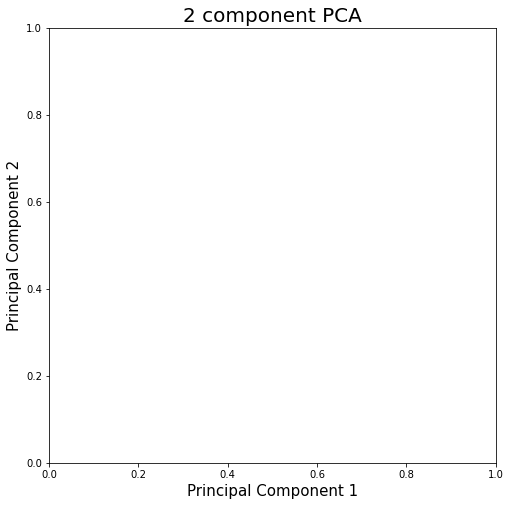

In [76]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)

populations = [
    'wGRE_9', 'wGRE_13', 'wSPA_5', 'fSPA_3',
    'fFRA_1', 'fGRE_10', 'wTUR_14', 'wSPA_4', 
    'wITA_8', 'fSPA_2', 'fGRE_9', 'fGRE_8', 
    'fCRO_5', 'wITA_7', 'wGRE_12', 'wGRE_11', 
    'wGRE_10', 'fITA_4', 'fGRE_6', 'fGRE_7'
]  # list of all 20 population names

# Color assignments for 'populations' list
colors = [
    'blue', 'blue', 'blue', 'red',  
    'red',  'red',  'blue', 'blue',
    'blue', 'red',  'red',  'red',  
    'red', 'blue', 'blue', 'blue', 
    'blue', 'red',  'red',  'red'
]

for labels, color in zip(populations, colors):
    indicesToKeep = finalDf['pops'] == populations
    ax.scatter(finalDf.iloc[:,0]
               , finalDf.iloc[:,1]
               , c = colors
               , s = 50)
# ax.legend(populations)
ax.grid()

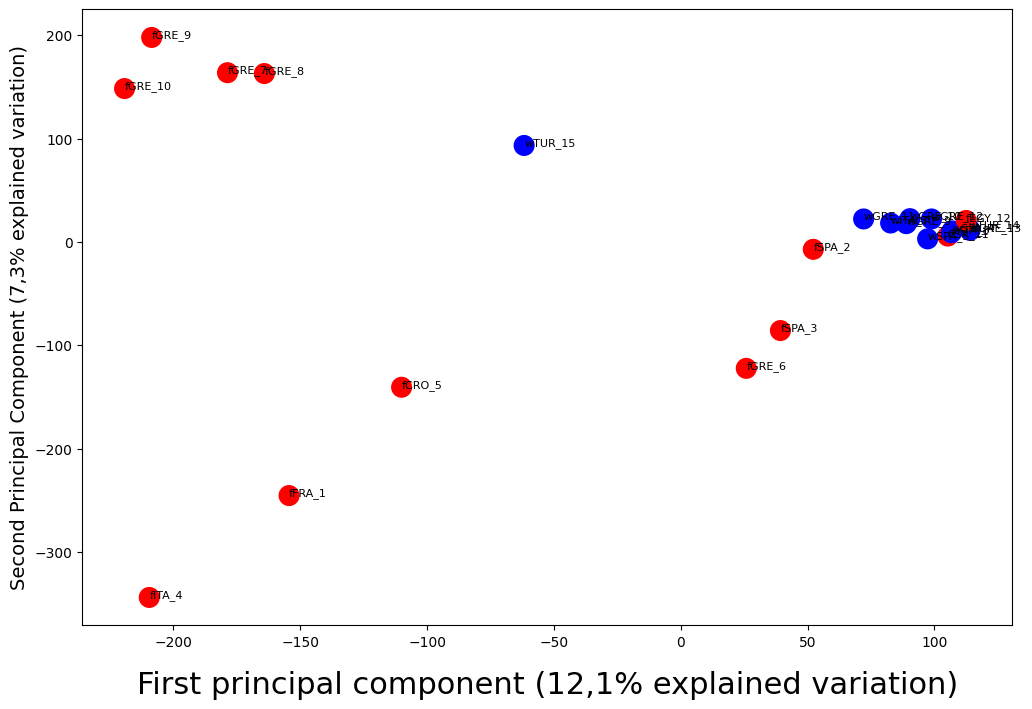

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))
plt.scatter(finalDf.iloc[:,0],finalDf.iloc[:,1],c=colors, s=200)
plt.xlabel('First principal component (12,1% explained variation)', fontsize=22, labelpad=15)
plt.ylabel('Second Principal Component (7,3% explained variation)', fontsize=14)


for i, txt in enumerate(finalDf.iloc[:,2]):
    plt.annotate(txt, (finalDf.iloc[i, 0], finalDf.iloc[i, 1]), fontsize=8)
